# Analysis of the precipitation at the octoberfest and its influence on the amount of visitors

## Import necessary libraries

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import timedelta
import numpy as np
import scipy.stats
from tueplots.constants.color import rgb
from tueplots import bundles
%matplotlib inline

## Functions

In [24]:
'''octoberfestday:
        input:  string in format yearmonthday
        output: true if octoberfest took place that day
'''
def octoberfestday(date):
    date = str(date)
    
    #convert date in datetimedate
    date = datetime.date(int(date[0:4]),int(date[4:6]),int(date[6:8]))

    #compute time of octoberfest in that year
    year = date.year
    posstartdate = datetime.date(year, 9, 16)
    weekdate = posstartdate.weekday()
    diff = 5 - weekdate
    if (diff <= -1):
        diff = 7 + diff
    startdate = datetime.date(year, 9, 16+diff)
    duration = octoberfestdata.loc[octoberfestdata['jahr'] == year]['dauer'].values[0]
    enddate = startdate + timedelta(days=int(duration)-1)
    
    #check if date is at time of octoberfest
    return (startdate <= date <= enddate)


'''getyear:
        input:  date in format yearmontday
        output: year as string
'''
def getyear(date):
    return str(date)[0:4]


'''corrcolor:
        input:  octoberfestduration
        output: corresponding color
'''
def corrcolor(durations):
    c = []
    for duration in octoberfestdata["dauer"]:
        if duration == 16:
            c.append(rgb.tue_darkblue)
        elif duration == 17:
            c.append(rgb.tue_orange)
        elif duration == 18:
            c.append(rgb.tue_red)
        else:
            # add zeros for years, were octoberfest didn't take place
            c.append("0")
    return c


'''precipitationtotal_daily:
      input:  daily precipitation in pandas dataframe
      output: total precipitation in time of octoberfest and duration of octoberfest as dictionary
'''
def precipitationtotal_daily(daily):
    totaldict = {}
    for index, row in daily.iterrows():
        year = getyear(row['MESS_DATUM'])
        year = int(year)
        if year in totaldict.keys():
            totaldict[year][0] = totaldict[year][0] + row[' RSK']
            
        else:
            totaldict[year] = [row[' RSK'], octoberfestdata.loc[octoberfestdata['jahr'] == year]['dauer'].iloc[0]]
    return totaldict


''' precipitationtotal_hourly:
        input:  hourly precipitation in pandas dataframe
        output: total precipitation in time of the octoberfest as dictionary
'''
def precipitationtotal_hourly(hourly):
    totaldict = {}
    for index, row in hourly.iterrows():
        year = getyear(row['MESS_DATUM'])
        year = int(year)
        if year in totaldict.keys():

           #only use positive values 
           if row['  R1'] >= 0:
               totaldict[year][0] = totaldict[year][0] + row['  R1']
        else:
            if row['  R1'] >= 0:
                totaldict[year] = [row['  R1'], octoberfestdata.loc[octoberfestdata['jahr'] == year]['dauer'].iloc[0]]
    return totaldict


''' precipitationday_hourly:
        input:  hourly precipitation in pandas dataframe
        output: total precipitation in time of the octoberfest from 10am to 10pm as dictionary
'''
def precipitationday_hourly(hourly):
    totaldict = {}
    for index, row in hourly.iterrows():
        year = getyear(row['MESS_DATUM'])
        year = int(year)

        #only use precipitation between 10am and 10pm
        day = int(str(row['MESS_DATUM'])[8:]) < 22 and int(str(row['MESS_DATUM'])[8:]) >= 10
        if year in totaldict.keys() and day:
            if row['  R1'] >= 0:
                totaldict[year][0] = totaldict[year][0] + row['  R1']
        elif day:
            if row['  R1'] >= 0:
                totaldict[year] = [row['  R1'],octoberfestdata.loc[octoberfestdata['jahr'] == year]['dauer'].iloc[0]]    
    return totaldict


''' weekendprecipitation:
        input:  hourly precipitation in pandas dataframe
        output: total precipitation in time of the octoberfest on the weekends as dictionary
'''
def weekendprecipitation(precipdata):
    weekenddict = {}
    for index, row in precipdata.iterrows():
        precipday = str(row['MESS_DATUM'])
        date = datetime.date(int(precipday[0:4]),int(precipday[4:6]),int(precipday[6:8]))
        year = getyear(row['MESS_DATUM'])
        year = int(year)
        weekday = date.weekday()
        day = int(str(row['MESS_DATUM'])[8:]) < 22 and int(str(row['MESS_DATUM'])[8:]) >= 10

        #only use precipitation on weekends
        if ((weekday == 5) or (weekday == 6)):
            #only use precipitation between 10am and 10pm
            if year in weekenddict.keys() and day:
                if row['  R1'] >= 0:
                    weekenddict[year][0] = weekenddict[year][0] + row['  R1']
            elif day:
                weekenddict[year] = [row['  R1'], octoberfestdata.loc[octoberfestdata['jahr'] == year]['dauer'].iloc[0]]
    return weekenddict

## Load data

Load daily precipitation data  
(Download from: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_03379_19540601_20221231_hist.zip)

Load daily precipitation data  
(Download from: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/tageswerte_KL_03379_akt.zip)

Load hourly precipitation data (historical)   
(Downloaded from: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/stundenwerte_RR_03379_19970707_20221231_hist.zip)  

Load hourly precipitation data (recent)
(Downloaded from: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/recent/stundenwerte_RR_03379_akt.zip) 
   
Load octoberfest data   
(Downloaded from: https://opendata.muenchen.de/dataset/oktoberfest/resource/e0f664cf-6dd9-4743-bd2b-81a8b18bd1d2?view_id=e619eb4d-fc3b-44cc-88ea-0086d710ee1f)   

In [25]:
'''
Read necessary precipitation data from the original files when using it for the first time.
'''
#hourlydata = pd.read_csv("hourly_data/munic/produkt_rr_stunde_19970707_20221231_03379.txt",sep=";")
#hourlydata_recent = pd.read_csv("hourly_data/recent/produkt_rr_stunde_20220714_20240114_03379.txt",sep=";")
#hourlydata = pd.concat([hourlydata, hourlydata_recent],ignore_index=True)
#dailydata = pd.read_csv("daily_data/munic/produkt_klima_tag_19540601_20221231_03379.txt", sep=";")
#dailydata_recent = pd.read_csv("daily_data/recent/produkt_klima_tag_20220714_20240114_03379.txt",sep=";")
#dailydata = pd.concat([dailydata,dailydata_recent],ignore_index=True)

'''
Add octoberfestdata for 2023.
'''
octoberfestdata = pd.read_csv("../dat/oktoberfest.csv")
unchanged_octoberfestdata = pd.read_csv("../dat/oktoberfest.csv")
all_years = np.arange(octoberfestdata['jahr'].min(),octoberfestdata['jahr'].max()+1)
octoberfestdata_all_years = pd.DataFrame({'jahr':all_years})
octoberfestdata = pd.merge(octoberfestdata_all_years,octoberfestdata, on ='jahr',how='left')

data2023 = pd.DataFrame({'jahr':[2023],'dauer':[18],'besucher_gesamt':[float(7.2)],'besucher_tag':[400.0]})
changed_octoberfestdata = pd.concat([octoberfestdata,data2023],ignore_index=True)

unchanged_data2023 = pd.DataFrame({'jahr':[2023],'dauer':[18],'besucher_gesamt':[float(7.2)],'besucher_tag':[400.0]})
unchanged_octoberfestdata = pd.concat([unchanged_octoberfestdata,unchanged_data2023],ignore_index=True)

Drop all data from the precipitation data from before 1985 and after 2019, but keep data from 2022 and 2023. Those are the years for which we have Oktoberfest visitor data. Also drop all the precipitation data from dates when the Oktoberfest didn't take place. Write the selected precipitation data to a csv file, so the whole dataset only needs to be reloaded when the data changes.

In [26]:
'''
Write necessary data to files an drop the rest to reduce the running time when using the same data again.
'''
#dailydata = dailydata[((20191231 >= dailydata['MESS_DATUM']) & (dailydata['MESS_DATUM'] >= 19850101)) | ((20231231 >= dailydata['MESS_DATUM']) & (20220101 <= dailydata['MESS_DATUM']))]
#dailydata = dailydata[dailydata['MESS_DATUM'].map(octoberfestday)]
#hourlydata = hourlydata[((2019123123 >= hourlydata['MESS_DATUM']) & (hourlydata['MESS_DATUM'] >= 1985010100)) | ((2023123123 >= hourlydata['MESS_DATUM']) & (2022010100 <= hourlydata['MESS_DATUM']))]
#hourlydata = hourlydata[hourlydata['MESS_DATUM'].map(octoberfestday)]
#dailydata.to_csv('octoberfest_daily.csv', index = True)
#hourlydata.to_csv('octoberfest_hourly.csv', index = True)

'''
Read filtered data from the files it was written to before. 
'''
dailydata = pd.read_csv('../dat/octoberfest_daily.csv', sep=",")
hourlydata = pd.read_csv('../dat/octoberfest_hourly.csv',sep=",")

## Visualization of the data used in the following analysis

In this step we look at the raw data to see if the values may have some obvious errors. Therefore we plot the precipitation for each day and the precipitation for each hour at the Oktoberfest.

In [27]:

'''
ax = dailydata.plot(x="MESS_DATUM",y=" RSK",kind="bar",xlabel="Date",ylabel="Precipitation [mm]",rot=90,legend=False)
previousdate = 1984
for date, tick in enumerate(ax.get_xticklabels()):
    year = int(getyear(dailydata["MESS_DATUM"].iloc[date]))
    if year == previousdate:
        tick.set_visible(False)
    previousdate = year
plt.show()

ax = hourlydata.plot(x="MESS_DATUM",y="  R1",kind="bar",xlabel="Date",ylabel="Precipitation [mm]",rot=90,legend=False,width=4)
previousdate = 1984
for date, tick in enumerate(ax.get_xticklabels()):
    year = int(getyear(hourlydata["MESS_DATUM"].iloc[date]))
    if year == previousdate:
        tick.set_visible(False)
    previousdate = year
plt.savefig("../fig/hourlydata_plot.pdf")
plt.tight_layout()
plt.show()
'''


'\nax = dailydata.plot(x="MESS_DATUM",y=" RSK",kind="bar",xlabel="Date",ylabel="Precipitation [mm]",rot=90,legend=False)\npreviousdate = 1984\nfor date, tick in enumerate(ax.get_xticklabels()):\n    year = int(getyear(dailydata["MESS_DATUM"].iloc[date]))\n    if year == previousdate:\n        tick.set_visible(False)\n    previousdate = year\nplt.show()\n\nax = hourlydata.plot(x="MESS_DATUM",y="  R1",kind="bar",xlabel="Date",ylabel="Precipitation [mm]",rot=90,legend=False,width=4)\npreviousdate = 1984\nfor date, tick in enumerate(ax.get_xticklabels()):\n    year = int(getyear(hourlydata["MESS_DATUM"].iloc[date]))\n    if year == previousdate:\n        tick.set_visible(False)\n    previousdate = year\nplt.savefig("../fig/hourlydata_plot.pdf")\nplt.tight_layout()\nplt.show()\n'

As we can see the plot with the daily precipitation includes precipitation amounts from 0mm to over 60mm. The data seems not to include any obvious errors. Thats different for the hourly data here the plot shows a range of around -1000mm to over 0mm precipitation per hour. Since negative precipitation doesn't make sense we need to have a closer look on how many data points the precipitation value doesn't make sense. 

In [28]:
#for index, row in hourlydata.iterrows():
#    if row['  R1'] < 0:
#        print(row['MESS_DATUM'])
    

We see that only on 23.09.2004 there is an error. This could be due to a measurement error. Since only one hour of all the hours at the time of the Oktoberfest has a value that can't be true we set the value from -999mm to 0mm and neglect the effect on our further analysis. We do so, because the Oktoberfest is at least 16days long, therefore one hour with a wrong value should not have a big impact on our further analysis, since we look at a minimum of 192 hours per Oktoberfest.

## Visualization of precipitation and visitor data
Visualization of the total precipitaion, the precipitation on each day from 10am to 10pm and the visitor numbers in the time of the Oktoberfest in the years from 1985 to 2023. Due to Covid the Octoberfest didn't take place in 2020 and 2021 so there is no data for these years.

Use the two for-loops in the code to label the heights of the bars and thereby highlight the difference between the total precipitation and  precipitation from 10am to 10pm.

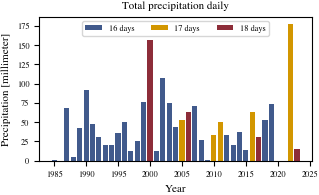

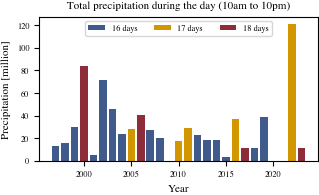

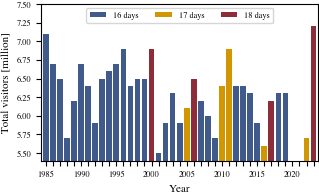

In [34]:
#compute total precipitation in the time of the octoberfest and plot it
octoberfestdata = changed_octoberfestdata
totalprecipitation_daily = precipitationtotal_daily(dailydata)
keys_daily = list(totalprecipitation_daily.keys())
values_daily = [item[0] for item in totalprecipitation_daily.values()]

plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
#plt.rcParams['font.family'] = 'Times New Roman'
plt.ylabel("Precipitation [millimeter]")
plt.xlabel("Year")
#for i, label in enumerate(keys_daily):
#    plt.text(keys_daily[i]-0.6,values_daily[i]+0.4,round(values_daily[i],2),fontsize='xx-small') 
plt.bar([key for key,val in totalprecipitation_daily.items() if val[1]==16],[val[0] for key,val in totalprecipitation_daily.items() if val[1]==16],color=rgb.tue_darkblue,label="16 days")
plt.bar([key for key,val in totalprecipitation_daily.items() if val[1]==17],[val[0] for key,val in totalprecipitation_daily.items() if val[1]==17],color=rgb.tue_orange,label="17 days")
plt.bar([key for key,val in totalprecipitation_daily.items() if val[1]==18],[val[0] for key,val in totalprecipitation_daily.items() if val[1]==18],color=rgb.tue_red,label="18 days")
plt.title("Total precipitation daily")

legend = plt.legend(loc='upper center',ncol=3)
plt.show()

totalprecipitationday_hourly = precipitationday_hourly(hourlydata)
keys_hourly = list(totalprecipitationday_hourly.keys())
values_hourly = [item[0] for item in totalprecipitationday_hourly.values()]
plt.ylabel("Precipitation [million]")
plt.xlabel("Year")
#for i, label in enumerate(keys_hourly):
#    plt.text(keys_hourly[i]-0.6,values_hourly[i]+0.4,round(values_hourly[i],2),fontsize='xx-small') 
plt.bar([key for key,val in totalprecipitationday_hourly.items() if val[1]==16],[val[0] for key,val in totalprecipitationday_hourly.items() if val[1]==16],color=rgb.tue_darkblue,label="16 days")
plt.bar([key for key,val in totalprecipitationday_hourly.items() if val[1]==17],[val[0] for key,val in totalprecipitationday_hourly.items() if val[1]==17],color=rgb.tue_orange,label="17 days")
plt.bar([key for key,val in totalprecipitationday_hourly.items() if val[1]==18],[val[0] for key,val in totalprecipitationday_hourly.items() if val[1]==18],color=rgb.tue_red,label="18 days")    

legend = plt.legend(loc='upper center',ncol=3)
plt.title("Total precipitation during the day (10am to 10pm)")
plt.show()

    
ax = octoberfestdata.plot(x="jahr",y="besucher_gesamt",kind="bar",color=corrcolor("dauer"),ylim=(octoberfestdata["besucher_gesamt"].min()-0.1,7.5),xlabel="Year",ylabel="Total visitors [million]",rot=0,width=0.8)
ax.containers[0].set_label('_nolegend')
years = ["1985","2005","2006"]
for bar, tick_label in zip(ax.containers[0], ax.get_xticklabels()):
    if str(tick_label)[-6:-2] in years:
        if str(tick_label)[-6:-2] == "1985":
            bar.set_label("16 days")
        if str(tick_label)[-6:-2] == "2005":
            bar.set_label("17 days")
        if str(tick_label)[-6:-2] == "2006":
            bar.set_label("18 days")

color, duration = plt.gca().get_legend_handles_labels()
changed = [0,1,2]
ax.legend([color[i] for i in changed], [duration[i] for i in changed])

for year, tick in enumerate(ax.get_xticklabels()):
    if (year % 5) != 0:
        tick.set_visible(False)

plt.legend(loc='upper center',ncol=3)
plt.savefig("../doc/fig/totalvisitors.pdf")
plt.show()

dropyears = octoberfestdata[(octoberfestdata['jahr'] == "2020") | (octoberfestdata['jahr'] == "2021")].index 
#octoberfestdata = octoberfestdata[(octoberfestdata['jahr'] != 2020) or (octoberfestdata['jahr'] != 2021)]
octoberfestdata.drop(dropyears, inplace = True)

Since the hourly precipitation for munich is only available from 1997 the plot with the precipitation at daytime has less years. Both precipitation plots show varying amounts of precipitation in each year. Also the plot of the amount of visitors varies between the different years. In the following analysis the goal is to see if the precipitation has an influence on the amount of visitors. The assumption is, that less vistors come to the Oktoberfest if there is more precipitation in any particular year.

## Is there a correlation between the amount of visitors and the amount of precipitation at the Oktoberfest?

Plot the total precipitation on the x-axis and the amount of visitors on the y-axis to see if there is a correlation. Here we use the mean precipitation per day and the mean visitors per day since the duration of the Oktoberfest is not always the same.

To label the data points in the plot with the corresponding year use the for loop in the code.

The precipitation data from 1985 to 2023 is used here.

Pearson correlation coefficient for the daily mean visitors an the daily mean precipitation:
-0.1912992689101533


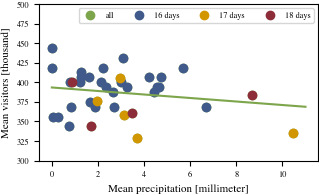

In [30]:
ax=plt.subplot()
octoberfestdata = unchanged_octoberfestdata
#if you want to look at the precipitaion since 1997 for the duration of the octoberfestdata use the following two line. Otherwise all the data available will be use.
#totalprecipitation_daily = precipitationtotal_hourly(hourlydata)
#octoberfestdata = octoberfestdata[(octoberfestdata['jahr'] >= 1997)]

# plots the mean precipitaion in comparison to the daily mean visitors
plt.scatter([(val[0]/val[1]) for key,val in totalprecipitation_daily.items()],1000*octoberfestdata['besucher_gesamt']/octoberfestdata['dauer'],color=rgb.tue_green,label="all")
m,b = np.polyfit([(val[0]/val[1]) for val in totalprecipitation_daily.values()], 1000*octoberfestdata['besucher_gesamt']/octoberfestdata['dauer'], deg=1)
func = str(m)+"x"+str(b)
plt.plot(np.arange(start=0,stop=12,step=1), m*np.arange(start=0,stop=12,step=1)+b,color=rgb.tue_green)

#compute the pearson correlation coefficient
xl = [(val[0]/val[1]) for key,val in totalprecipitation_daily.items()]
yl = [octoberfestdata['besucher_gesamt']/octoberfestdata['dauer']][0].to_list()
xlnp = np.array(xl)
ylnp = np.array(yl)
print("Pearson correlation coefficient for the daily mean visitors an the daily mean precipitation:") 
print(scipy.stats.pearsonr(xlnp,ylnp)[0])
years = list(range(1985,2020))

years.append(2022)
years.append(2023)
#labels dots with corresponding year
#for i, label in enumerate(years):
#    print(i)
#    print(label)
#    print(xl[i])
#    if label == 2023:
#        plt.text(xl[i],yl[i],label,fontsize='xx-small')
    

plt.scatter([(val[0]/16) for key,val in totalprecipitation_daily.items() if val[1] == 16], [1000*octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]/16 for key,val in totalprecipitation_daily.items() if val[1] == 16], label="16 days",color=rgb.tue_darkblue)
m,b = np.polyfit([(val[0]/16) for val in totalprecipitation_daily.values() if val[1] == 16], [1000*octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]/16 for key,val in totalprecipitation_daily.items() if val[1] == 16], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=12,step=1), m*np.arange(start=0,stop=12,step=1)+b,color=rgb.tue_darkblue)

plt.scatter([(val[0]/17) for key,val in totalprecipitation_daily.items() if val[1] == 17], [1000*octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]/17 for key,val in totalprecipitation_daily.items() if val[1] == 17], label="17 days",color=rgb.tue_orange)
m,b = np.polyfit([(val[0]/17) for val in totalprecipitation_daily.values() if val[1] == 17], [1000*octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]/17 for key,val in totalprecipitation_daily.items() if val[1] == 17], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=12,step=1), m*np.arange(start=0,stop=12,step=1)+b,color=rgb.tue_orange)

plt.scatter([(val[0]/18) for key,val in totalprecipitation_daily.items() if val[1] == 18], [1000*octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]/18 for key,val in totalprecipitation_daily.items() if val[1] == 18], label="18 days",color=rgb.tue_red)
m,b = np.polyfit([(val[0]/18) for val in totalprecipitation_daily.values() if val[1] == 18], [1000*octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]/18 for key,val in totalprecipitation_daily.items() if val[1] == 18], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=12,step=1), m*np.arange(start=0,stop=12,step=1)+b,color=rgb.tue_red)
ax.set_xlabel('Mean precipitation [millimeter]')
ax.set_ylabel('Mean visitors [thousand]')
legend = ax.legend(loc='upper right',ncol=4)
plt.ylim(300,500)
plt.show()

The computed Pearson correlation coefficient for the mean of the daily precipitation and the mean of daily visitors is -0.1913. This only corresponds to a weak correlation. The minus indicates that it is a negative correalation which means that the amount of visitors decreases when the amount of precipitaion increases. Contrary to our expectation the plots show only a weak negative correalation. To rule out the possibility that the daily precipitation contains precipitation outside of the opening hours of the Oktoberfest we now look at the mean precipitation against the mean vistitors but only use the *hourly* precipitation data from 10am to 10pm. The precipitation at night shouldn't have an impact on the number of visitors. 

Here the available data begins in 1997 so we lose 12 years for the analysis.

Pearson correlation coefficient for the daily mean visitors an the daily mean precipitatio from 10am to 10pm:
-0.22764282213539766


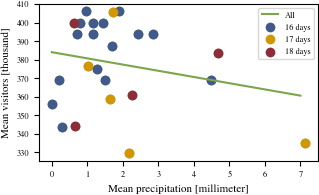

In [31]:
totalprecipitation_hourly = precipitationday_hourly(hourlydata)
octoberfestdata = unchanged_octoberfestdata
octoberfestdata = octoberfestdata[(octoberfestdata['jahr'] >= 1997)]


#compute the pearson correlation coefficient
xl = [val[0]/val[1] for key,val in totalprecipitation_hourly.items()]
yl = [octoberfestdata['besucher_gesamt']/octoberfestdata['dauer']][0].to_list()
xlnp = np.array(xl)
ylnp = np.array(yl)
print("Pearson correlation coefficient for the daily mean visitors an the daily mean precipitatio from 10am to 10pm:")
print(scipy.stats.pearsonr(xlnp, ylnp)[0])

ax=plt.subplot()
#print([key for key,val in totalprecipitation.items() if val[1] == 16]
plt.scatter([val[0]/val[1] for key,val in totalprecipitation_hourly.items()],1000*octoberfestdata['besucher_gesamt']/octoberfestdata['dauer'],color=rgb.tue_green)
m,b = np.polyfit([val[0]/val[1] for val in totalprecipitation_hourly.values()], 1000*octoberfestdata['besucher_gesamt']/octoberfestdata['dauer'], deg=1)
func = str(m)+"x"+str(b)
plt.plot(np.arange(start=0,stop=8,step=1), m*np.arange(start=0,stop=8,step=1)+b,color=rgb.tue_green,label="All")

plt.scatter([val[0]/16 for key,val in totalprecipitation_hourly.items() if val[1] == 16], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/16 for key,val in totalprecipitation_hourly.items() if val[1] == 16], label="16 days",color=rgb.tue_darkblue)
m,b = np.polyfit([val[0]/16 for val in totalprecipitation_hourly.values() if val[1] == 16], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/16 for key,val in totalprecipitation_hourly.items() if val[1] == 16], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=8,step=1), m*np.arange(start=0,stop=8,step=1)+b,color=rgb.tue_darkblue)

plt.scatter([val[0]/17 for key,val in totalprecipitation_hourly.items() if val[1] == 17], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/17 for key,val in totalprecipitation_hourly.items() if val[1] == 17], label="17 days",color=rgb.tue_orange)
m,b = np.polyfit([val[0]/17 for val in totalprecipitation_hourly.values() if val[1] == 17], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/17 for key,val in totalprecipitation_hourly.items() if val[1] == 17], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=8,step=1), m*np.arange(start=0,stop=8,step=1)+b,color=rgb.tue_orange)

plt.scatter([val[0]/18 for key,val in totalprecipitation_hourly.items() if val[1] == 18], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/18 for key,val in totalprecipitation_hourly.items() if val[1] == 18], label="18 days",color=rgb.tue_red)
m,b = np.polyfit([val[0]/18 for val in totalprecipitation_hourly.values() if val[1] == 18], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/18 for key,val in totalprecipitation_hourly.items() if val[1] == 18], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=8,step=1), m*np.arange(start=0,stop=8,step=1)+b,color=rgb.tue_red)

ax.set_xlabel('Mean precipitation [millimeter]')
ax.set_ylabel('Mean visitors [thousand]')
legend = ax.legend(loc='upper right')
plt.savefig("../doc/fig/totalprecipitation.pdf")
plt.show()

Even after not including the precipitation at night and in the morning there is still only a weak correlation. One explanation for that could be that the Oktoberfest is at least 16 days long. This provides visitors with numerous alternative dates to attend the Oktoberfest in case the day they initially planned for is particularly rainy. This means that the precipitation only influences vistors that can't make it at another date. This could explain why the green line in the plot above shows only a slight decrease in visitor numbers when there is greater precipitation.

The fact that the absolute value of the correlation increases from 0.1913 to 0.2276 by 0.04 in comparison to the daily precipitation shows that the precipitation at day has a bigger influence.


Now we have a look if there is a stronger correlation between the amount of visitors at the Oktoberfest if we only consider the precipitation on Saturday and Sunday. An assumption could be that more vistors come on the weekend in comparison to the rest of the week. So the precipitation on the weekend should then have a greater influence on the total number of visitors.

Pearson correlation coefficient for the daily mean visitors an the daily mean precipitation on the weekends:
-0.21400579832359704


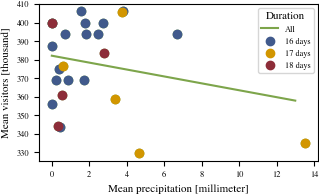

In [32]:
octoberfestdata = unchanged_octoberfestdata
octoberfestdata = octoberfestdata[(octoberfestdata['jahr'] >= 1997)]
totalprecipitation_weekend = weekendprecipitation(hourlydata)

xl = [val[0]/val[1] for key,val in totalprecipitation_weekend.items()]
yl = [octoberfestdata['besucher_gesamt']/octoberfestdata['dauer']][0].to_list()
xlnp = np.array(xl)
ylnp = np.array(yl)
print("Pearson correlation coefficient for the daily mean visitors an the daily mean precipitation on the weekends:")
print(scipy.stats.pearsonr(xlnp, ylnp)[0])
ax=plt.subplot()
plt.scatter([val[0]/6 for key,val in totalprecipitation_weekend.items()],1000*octoberfestdata['besucher_gesamt']/octoberfestdata['dauer'],color=rgb.tue_green)
m,b = np.polyfit([val[0]/6 for val in totalprecipitation_weekend.values()], 1000*octoberfestdata['besucher_gesamt']/octoberfestdata['dauer'], deg=1)
func = str(m)+"x"+str(b)
plt.plot(np.arange(start=0,stop=14,step=1), m*np.arange(start=0,stop=14,step=1)+b,color=rgb.tue_green,label="All")

#print([key for key,val in totalprecipitation.items() if val[1] == 16]
plt.scatter([val[0]/6 for key,val in totalprecipitation_weekend.items() if val[1] == 16], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/16 for key,val in totalprecipitation_weekend.items() if val[1] == 16], label="16 days",color=rgb.tue_darkblue)
m,b = np.polyfit([val[0]/6 for val in totalprecipitation_weekend.values() if val[1] == 16], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/16 for key,val in totalprecipitation_weekend.items() if val[1] == 16], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=14,step=1), m*np.arange(start=0,stop=14,step=1)+b,color=rgb.tue_darkblue)


plt.scatter([val[0]/6 for key,val in totalprecipitation_weekend.items() if val[1] == 17], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/17 for key,val in totalprecipitation_weekend.items() if val[1] == 17], label="17 days",color=rgb.tue_orange)
m,b = np.polyfit([val[0]/6 for val in totalprecipitation_weekend.values() if val[1] == 17], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/17 for key,val in totalprecipitation_weekend.items() if val[1] == 17], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=14,step=1), m*np.arange(start=0,stop=14,step=1)+b,color=rgb.tue_orange)

plt.scatter([val[0]/6 for key,val in totalprecipitation_weekend.items() if val[1] == 18], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/18 for key,val in totalprecipitation_weekend.items() if val[1] == 18], label="18 days",color=rgb.tue_red)
m,b = np.polyfit([val[0]/6 for val in totalprecipitation_weekend.values() if val[1] == 18], [octoberfestdata.loc[octoberfestdata['jahr'] == key]['besucher_gesamt'].iloc[0]*1000/18 for key,val in totalprecipitation_weekend.items() if val[1] == 18], deg=1)
func = str(m)+"x"+str(b)
#plt.plot(np.arange(start=0,stop=14,step=1), m*np.arange(start=0,stop=14,step=1)+b,color=rgb.tue_red)
ax.set_xlabel('Mean precipitation [millimeter]')
ax.set_ylabel('Mean visitors [thousand]')
legend = ax.legend(loc='upper right', title="Duration")
plt.show()

Using only the weekend brings no stronger correlation between the number of visitors and the amound of precipitation.